## Importin from Librarries

In [1]:
import time
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import numpy as np
from torchvision import transforms
import torch
from tqdm import tqdm
from spikingjelly.activation_based import neuron, functional, surrogate , encoding , layer
import math
import pyspike as spk

## Creating Our Neuron Model (PLIF)

In [2]:
class PLIFNode(neuron.BaseNode):
    def __init__(self, init_tau=2.0, v_threshold=1.0, v_reset=0.0, surrogate_function=surrogate.ATan() ,  detach_reset = True ):
        super().__init__(v_threshold, v_reset, surrogate_function)
        init_w = - math.log(init_tau - 1)
        self.w = nn.Parameter(torch.tensor(init_w, dtype=torch.float))
        self.w.requires_grad = True
        self.fire_mask = 0
        self.spike = 0

    def neuronal_charge(self, dv: torch.Tensor):
        if self.v_reset is None:
            # self.v += dv - self.v * self.w.sigmoid()
            self.v += (dv - self.v) * self.w.sigmoid()
        else:
            # self.v += dv - (self.v - self.v_reset) * self.w.sigmoid()
            self.v += (dv - (self.v - self.v_reset)) * self.w.sigmoid()

    def neuronal_fire(self):
        self.spike = self.surrogate_function(self.v - self.v_threshold)
        return self.spike

    def neuronal_reset(self , spike):
        if self.v_reset is None:
            self.v = self.v - spike * self.v_threshold
        else:
            self.v = (1. - spike) * self.v + spike * self.v_reset
        

    def tau(self):
        return 1 / self.w.data.sigmoid().item()


    def extra_repr(self):
        return f'v_threshold={self.v_threshold}, v_reset={self.v_reset}, tau={self.tau()}'


## Creating LIF

## Creating trainloader and testloader

In [3]:
## Download datasets
train_dataset = torchvision.datasets.MNIST(
    root = "'./data'",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

## DataLoaders
train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size = 32,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

test_data_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

## Creatin Network

In [4]:
class SNN(nn.Module):
    def __init__(self , layer1_number = 50 , layer2_number = 10 , T = 10):
        super().__init__()


        self.count = 0
        
        self.layer1_number = layer1_number
        self.layer2_number = layer2_number
        self.T = T
        
        
        self.s_layer1 = []
        self.s_layer2 = []
        self.s_layer3 = []
        
        self.flatten = layer.Flatten()
        self.fc1 = layer.Linear(28*28, 50, bias=False) # Input
        self.lif1 = LIFNode(surrogate_function=surrogate.ATan())
        self.fc2 = layer.Linear(50, 10, bias=False) # Input
        self.lif2 = LIFNode(surrogate_function=surrogate.ATan())
        self.fc3 = layer.Linear(10, 10, bias=False) # Input
        self.lif3 = LIFNode(surrogate_function=surrogate.ATan())
        

    def forward(self, x: torch.Tensor):

        x = self.flatten(x)
        x = self.lif1(self.fc1(x))
        self.s_layer1 = x
        x = self.lif2(self.fc2(x))
        self.s_layer2 = x 
        x = self.lif3(self.fc3(x))
        self.s_layer3 = x

        
        return x , [self.s_layer1 , self.s_layer2 , self.s_layer3]

## Spike Train Recording Function

In [5]:
def bach_records_update(layer_activations, t , bach_records):
    
    for i , layer_activation in enumerate(layer_activations):

        if t == 0 :
    
                layer_neurons_records = []
                for _ in range(layer_activation.size(1)):
                    layer_neurons_records.append(layer_activation[: , _].reshape(-1 , 1))
    
                bach_records.append(layer_neurons_records)
    
    
        else :

            for _ in range(layer_activation.size(1)):
                bach_records[i][_] = torch.cat((bach_records[i][_] , layer_activation[: , _].reshape(-1 , 1)) ,  dim = 1)    
    

    return bach_records

## Training Our Network

In [7]:
T= 10
epochs = 6
momentum = 0.9

net = SNN()
start_epoch = 0


optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3 )
encoder = encoding.PoissonEncoder()

all_records = []


# Training
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    net.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    epoch_record = []

    for img, label in train_data_loader:
        optimizer.zero_grad()
        img = img
        label = label
        label_onehot = F.one_hot(label, 10).float()
        
        out_fr = 0

        bach_records = [] # array of shape [*NumberOfLayers[(tensors , ... of shape (batchImageNumbers*Time) which represent every neuron in layer)]]
        
        for t in range(T):
            
            encoded_img = encoder(img)
            out_fr , layers_spikes = net(img)
            bach_records = bach_records_update(layers_spikes , t , bach_records)

        epoch_record.append(bach_records)
            

        
        out_fr = out_fr/T
        loss = F.mse_loss(out_fr, label_onehot) # + Synchrony
        loss.backward(retain_graph=True)
        optimizer.step()

        train_samples += label.numel() # number of elemets
        train_loss += loss.item()*label.numel()
        # The correct rate is calculated as follows:
        # The subscript i of the neuron with the highest firing rate in the output layer
        # is considered as the result of classification.
        train_acc += (out_fr.argmax(1)==label).float().sum().item()

        # After optimizing the parameters, the state of the network should be reset
        # because the neurons of the SNN have “memory”.
        functional.reset_net(net)


    all_records.append(epoch_record)
    train_time = time.time()
    train_speed = train_samples/(train_time - start_time)
    train_loss /= train_samples
    train_acc /= train_samples
    print(train_acc)

0.2569166666666667
0.4036
0.49378333333333335
0.5792666666666667
0.5923166666666667
0.59785


In [6]:
#cython language_level=3




# HAVASET BE IN BASHE KE MOMKENE C EMPTY BRAGARDEH VAGHTI N1 SPIKY NADASHTE BASHE


def Interpolate(a, b, t):

    
    if t < a and a < b:  return a
    if t < b and b <= a: return b
    if t > b:            return b    
    return t               # interpolation


def get_tau(spikes1, spikes2, i, j , max_tau , MRTS):


    ## "distances" to neighbor: F/P=future/past, 1/2=N in spikesN.
    mF1 = max_tau
    mP1 = max_tau
    mF2 = max_tau
    mP2 = max_tau
    
    if i < len(spikes1)-1 and i > -1:
        mF1 = (spikes1[i+1]-spikes1[i])
    if j < len(spikes2)-1 and j > -1:
        mF2 = (spikes2[j+1]-spikes2[j])
    if i > 0:
        mP1 = (spikes1[i]-spikes1[i-1])
    if j > 0:
        mP2 = (spikes2[j]-spikes2[j-1])

    mF1, mF2, mP1, mP2 = mF1/2., mF2/2., mP1/2., mP2/2.
    MRTS /= 4.

    if i<0 or j<0 or spikes1[i] <= spikes2[j]:
        s1F = Interpolate(mP1, mF1, MRTS)
        s2P = Interpolate(mF2, mP2, MRTS)
        return min(s1F, s2P)
    else:
        s1P = Interpolate(mF1, mP1, MRTS)
        s2F = Interpolate(mP2, mF2, MRTS)
        return min(s1P, s2F)


def coincidence_single_profile_cython(spikestensor1, spikestensor2, t_start, t_end, max_tau, TotalRegularization , MRTS=0.):

    spikes1 = ((torch.nonzero(spikestensor1)).view(1, -1)).numpy()[0]
    spikes2 = ((torch.nonzero(spikestensor2)).view(1,-1)).numpy()[0]
    

    N1 = len(spikes1)
    N2 = len(spikes2)

    times = []
    
    if N2 == 0 :

        spikes2 = np.append(spikes2 , np.array([100000]))
        N2 = len(spikes2)
    
    j = -1
    c = np.zeros(N1) 
    interval = t_end - t_start

    true_max = t_end - t_start
    if max_tau > 0:
        true_max = min(true_max, 2*max_tau)

    for i in range(N1):
        
        while j < N2-1 and spikes2[j+1] < spikes1[i]:
            
            # move forward until spikes2[j] is the last spike before spikes1[i]
            # note that if spikes2[j] is after spikes1[i] we dont do anything
            
            j += 1

        tau1 = get_tau(spikes1, spikes2, i, j, true_max, MRTS)

        

        if j > -1 and abs(spikes1[i]-spikes2[j]) < tau1: #حداقل یه اسپایک جی گیر اوردیم و به علاوه یک شده در واقع یه اسپایک به جز اسپایک اول قبل اسپایکمون بوده
            c[i] = 1

        if j < N2-1 and (j < 0 or spikes2[j] < spikes1[i]): 
            
            # in case spikes2[j] is before spikes1[i] it has to be the one 
            # right before (see above), hence we move one forward and also 
            # check the next spike
            
            j += 1

            tau2 = get_tau(spikes1, spikes2, i, j, true_max, MRTS)
            
            if abs(spikes2[j]-spikes1[i]) < tau2:
                
                # current spike in st1 is coincident
                
                c[i] = 1



        if c[i] == 0 :

            part = spikestensor1[i]
    
            times.append([t for t in range(int(spikes1[i] - tau1 + 1) , int(spikes1[i] + tau2 + 1))])
            for t in range(int(spikes1[i] - tau1 + 1) , int(spikes1[i] + tau2 + 1)) :


                    part = part - (spikestensor2[t])
            
            
            TotalRegularization +=  part**2
            
    return TotalRegularization

In [10]:
np.random.poisson(1, 10)

array([1, 1, 2, 3, 1, 1, 0, 1, 0, 0])

## Poisson Spike Generator

In [11]:
class PoissonSpike:
    def __init__(self, data, time=500, dt=0.1, max_freq=128, min_freq=0):
        """
        Generate Poisson spike trains
        :param data:
        :param time:
        :param dt:
        :param max_freq:
        :param min_freq
        """
        data = np.array(data).reshape(-1)
        self.data = (data - np.min(data.min())) / (np.max(data) - np.min(data)) if data.size != 1 else data
        self.time = time
        self.dt = dt

        self.max_freq = max_freq
        self.freq_data = self.data * (max_freq - min_freq) + min_freq
        self.norm_data = 1000. / (self.freq_data + 1e-10)

        fires = [
            np.cumsum(np.random.poisson(cell / dt, (int(time / cell + 1)))) * dt
            for cell in self.norm_data
        ]
        self.fires = np.array(fires, dtype=object)

        self.spikes = np.zeros((data.shape[0], int(time/dt)))

        for s, f in zip(self.spikes, self.fires):
            f = f[f < time]  # round
            s[np.array(f/dt, dtype=int)] = 1    # {0,1} spikes

        self.monitor = {
            's': self.spikes,
            'f': self.fires,
        }


## Test Regularization Model

In [12]:
class LIFNode(neuron.BaseNode):
    def __init__(self, init_tau=2.0, v_threshold=1.0, v_reset=0.0, surrogate_function=surrogate.ATan() ,  detach_reset = True ):
        super().__init__(v_threshold, v_reset, surrogate_function)
        init_w = - math.log(init_tau - 1)
        self.w = torch.tensor(init_w, dtype=torch.float)
        self.fire_mask = 0
        self.spike = 0

    def neuronal_charge(self, dv: torch.Tensor):
        if self.v_reset is None:
            # self.v += dv - self.v * self.w.sigmoid()
            self.v += (dv - self.v) * self.w.sigmoid()
        else:
            # self.v += dv - (self.v - self.v_reset) * self.w.sigmoid()
            self.v += (dv - (self.v - self.v_reset)) * self.w.sigmoid()

    def neuronal_fire(self):
        self.spike = self.surrogate_function(self.v - self.v_threshold)
        return self.spike

    def neuronal_reset(self , spike):
        if self.v_reset is None:
            self.v = self.v - spike * self.v_threshold
        else:
            self.v = (1. - spike) * self.v + spike * self.v_reset
        

    def tau(self):
        return 1 / self.w.data.sigmoid().item()


    def extra_repr(self):
        return f'v_threshold={self.v_threshold}, v_reset={self.v_reset}, tau={self.tau()}'


In [372]:
class test(nn.Module):
    def __init__(self , layer1_number = 50  , T = 10):
        super().__init__()        
        
        self.s_layer1 = []

        self.fc1 = layer.Linear(layer1_number, 2, bias=False) # Input
        self.weight = self.fc1.weight
        self.lif1 = LIFNode(v_threshold = 0.2 , surrogate_function=surrogate.ATan())
        

    def forward(self, x: torch.Tensor):

        x = self.lif1(self.fc1(x))
        self.s_layer1 = x

        
        return x , [self.s_layer1] , self.weight
        

In [674]:
#cython language_level=3




# HAVASET BE IN BASHE KE MOMKENE C EMPTY BRAGARDEH VAGHTI N1 SPIKY NADASHTE BASHE


def Interpolate(a, b, t):

    
    if t < a and a < b:  return a
    if t < b and b <= a: return b
    if t > b:            return b    
    return t               # interpolation


def get_tau(spikes1, spikes2, i, j , max_tau , MRTS):


    ## "distances" to neighbor: F/P=future/past, 1/2=N in spikesN.
    mF1 = max_tau
    mP1 = max_tau
    mF2 = max_tau
    mP2 = max_tau
    
    if i < len(spikes1)-1 and i > -1:
        mF1 = (spikes1[i+1]-spikes1[i])
    if j < len(spikes2)-1 and j > -1:
        mF2 = (spikes2[j+1]-spikes2[j])
    if i > 0:
        mP1 = (spikes1[i]-spikes1[i-1])
    if j > 0:
        mP2 = (spikes2[j]-spikes2[j-1])

    mF1, mF2, mP1, mP2 = mF1/2., mF2/2., mP1/2., mP2/2.
    MRTS /= 4.

    if i<0 or j<0 or spikes1[i] <= spikes2[j]:
        s1F = Interpolate(mP1, mF1, MRTS)
        s2P = Interpolate(mF2, mP2, MRTS)
        return min(s1F, s2P)
    else:
        s1P = Interpolate(mF1, mP1, MRTS)
        s2F = Interpolate(mP2, mF2, MRTS)
        return min(s1P, s2F)


def coincidence_single_profile_cython(spikestensor1, spikestensor2, t_start, t_end, max_tau , MRTS=0.):


    TotalRegularization = 0

    spikes1 = ((torch.nonzero(spikestensor1)).view(1, -1)).numpy()[0]
    spikes2 = ((torch.nonzero(spikestensor2)).view(1,-1)).numpy()[0]
    

    N1 = len(spikes1)
    N2 = len(spikes2)

    times = []
    
    if N2 == 0 :

        spikes2 = np.append(spikes2 , np.array([10000000]))
        N2 = len(spikes2)
    
    j = -1
    c = np.zeros(N1) 
    interval = t_end - t_start

    true_max = t_end - t_start
    if max_tau > 0:
        true_max = min(true_max, 2*max_tau)

    for i in range(N1):

        tau1 = 0
        tau2 = 0
        
        while j < N2-1 and spikes2[j+1] < spikes1[i]:
            
            # move forward until spikes2[j] is the last spike before spikes1[i]
            # note that if spikes2[j] is after spikes1[i] we dont do anything
            
            j += 1

        tau1 = get_tau(spikes1, spikes2, i, j, true_max, MRTS)

        

        if j > -1 and abs(spikes1[i]-spikes2[j]) < tau1: #حداقل یه اسپایک جی گیر اوردیم و به علاوه یک شده در واقع یه اسپایک به جز اسپایک اول قبل اسپایکمون بوده
            c[i] = 1

        if j < N2-1 and (j < 0 or spikes2[j] < spikes1[i]): 
            
            # in case spikes2[j] is before spikes1[i] it has to be the one 
            # right before (see above), hence we move one forward and also 
            # check the next spike
            
            j += 1

            tau2 = get_tau(spikes1, spikes2, i, j, true_max, MRTS)
            
            if abs(spikes2[j]-spikes1[i]) < tau2:
                
                # current spike in st1 is coincident
                
                c[i] = 1



        if c[i] == 0 :

            part = 1
    
            for t in range(int(spikes1[i] - tau1 + 1) , int(spikes1[i] + tau2 + 1)) :


                if ( t_start <= t <= t_end ) :


                    if spikes1[i] > t and abs(spikes1[i] - t) < tau1:

                        part = part - (spikestensor2[t])
                        times.append(t)


                    elif spikes1[i] < t and abs(spikes1[i] - t) < tau2:

                        
                        part = part - (spikestensor2[t])
                        times.append(t)

                    
                    elif spikes1[i] == t :

                        part = part - (spikestensor2[t])
                        times.append(t)



            TotalRegularization +=  part**2


        print(times)
            
    return TotalRegularization , N1

In [ ]:
a = torch.tensor([0 , 1 , 0 , 1 , 0 , 1 , 0 , 0 , 0 , 0])

In [693]:
T = 100
spikes = torch.tensor(PoissonSpike(np.random.random(100),time=T,dt=1 , max_freq = 2500 , min_freq = 1800).spikes).float()
network = test(layer1_number = 100)

epoch_record = []
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3 )
losses = []
N = []


for epoch in range(120):

    network.train()
    loss = 0

    optimizer.zero_grad()


    for t in range (T):

        out_fr , layers_spikes , w = network(spikes[: , t])
        
        if t == 0 :

            record = layers_spikes[0].reshape(-1 , 1)


        else :

            record = torch.cat((record , layers_spikes[0].reshape(-1 , 1)) , dim = 1)



    loss1 , N1 = coincidence_single_profile_cython(record[0 , :], record[1 , :], 0 , 99 , max_tau = 2)
    loss2 , N2 = coincidence_single_profile_cython(record[1 , :], record[0 , :], 0 , 99 , max_tau = 2)

    loss = loss1 + loss2 


    if loss == 0 :


        losses.append(loss1+loss2)
        N.append(N1+N2)

        pass

    else:
    

    
        print(N1+N2)
        N.append(N1+N2)
        losses.append(loss1+loss2)
        loss.backward(retain_graph = True)
        print("total loss" , loss)
        print("synchrony loss" ,  loss1 + loss2)
        print (record)
        optimizer.step()
        functional.reset_net(network)



64
total loss tensor(64., grad_fn=<AddBackward0>)
synchrony loss tensor(64., grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
         0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
         1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
         1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 0., 0., 0., 0.

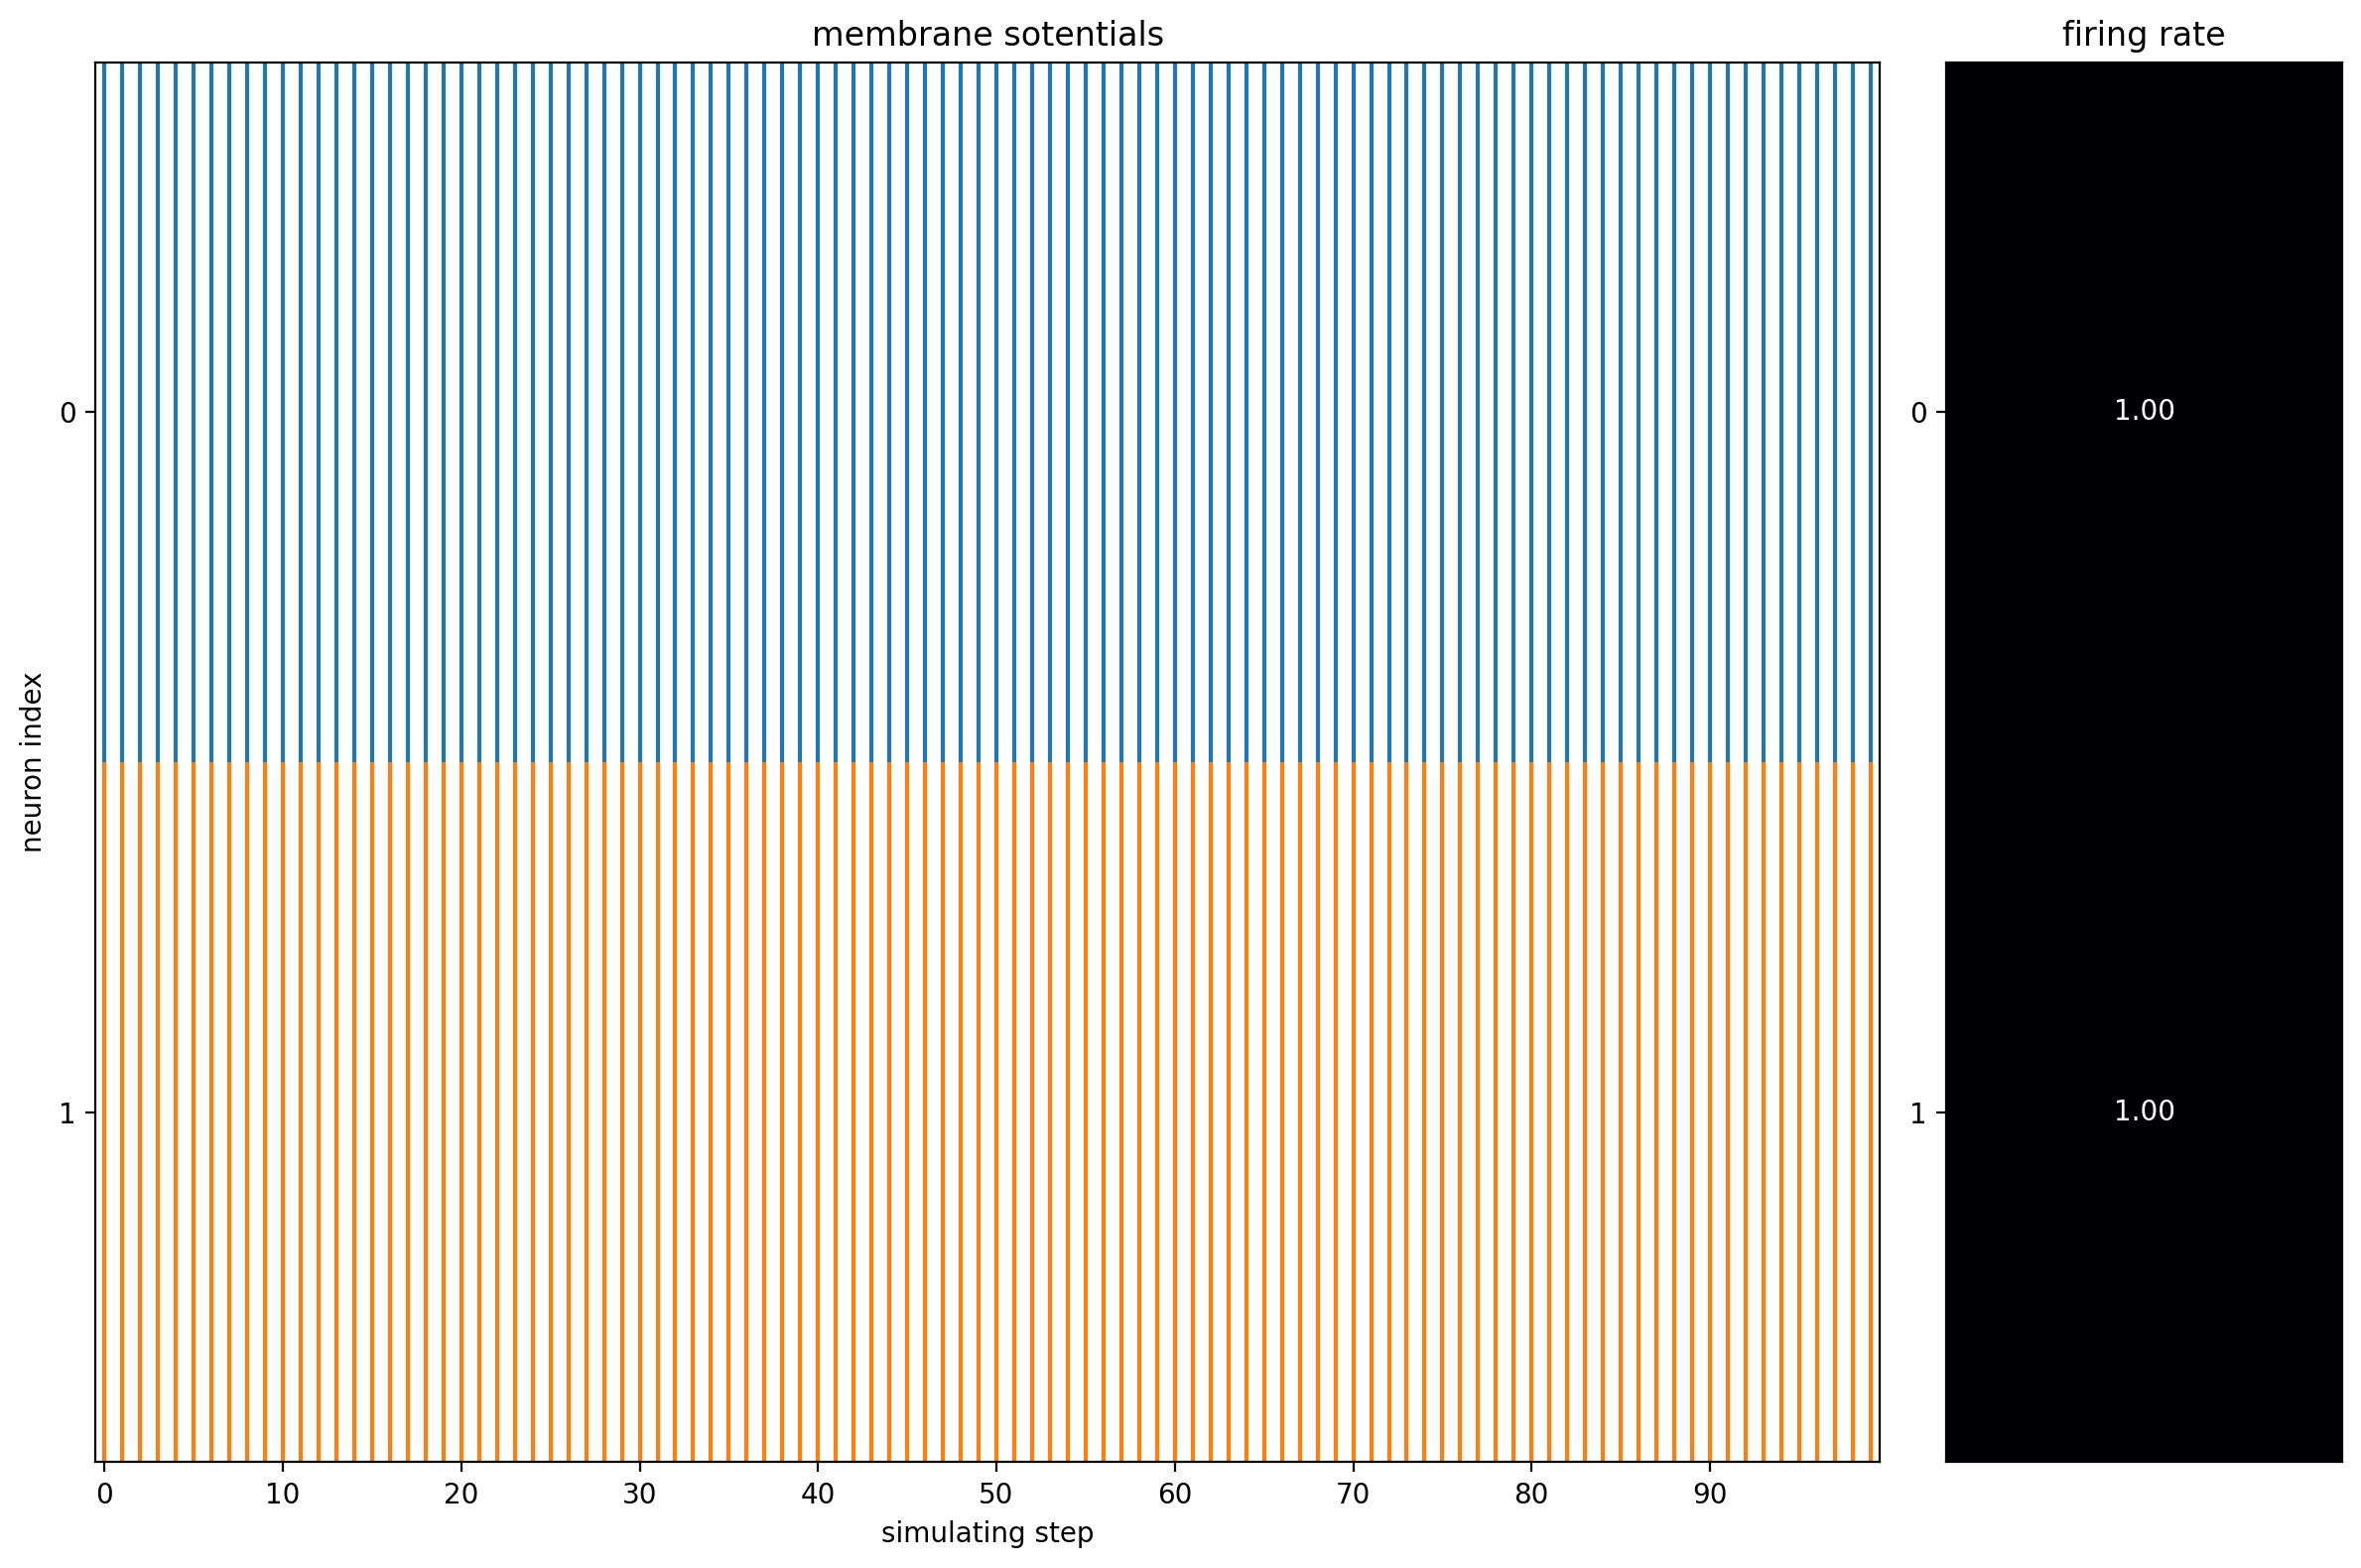

In [694]:
from spikingjelly import visualizing

s_list = torch.cat((record[0 , :].reshape(-1,1) , record[1 , :].reshape(-1 , 1)) , dim = 1)
s_list.shape

figsize = (12, 8)
dpi = 200

visualizing.plot_1d_spikes(spikes=s_list.detach().numpy(), title='membrane sotentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()

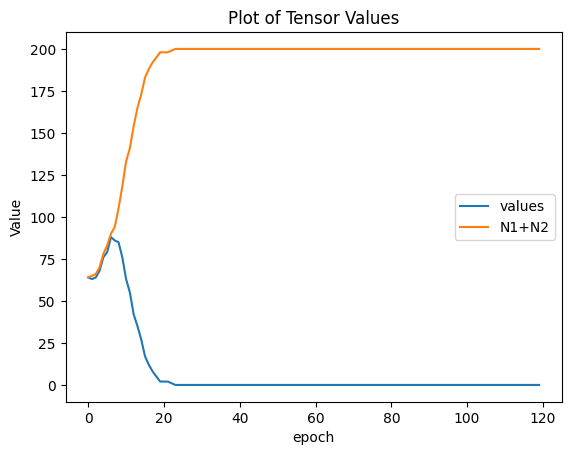

mean of unsynchroned neuron:  tensor(8.5000, grad_fn=<DivBackward0>)


In [695]:
import matplotlib.pyplot as plt

values = []
# Extract the values from the tensors
for tensor in losses :

    if tensor == 0 :

        values.append(tensor)

    else:

        values.append(tensor.item())


# Plot the values
plt.plot(values, label='values')
plt.plot(N, label='N1+N2')
plt.xlabel('epoch')
plt.ylabel('Value')
plt.title('Plot of Tensor Values')
plt.legend()
plt.show()


print("mean of unsynchroned neuron: " , sum(losses)/len(losses))

In [696]:
T = 100
spikes = torch.tensor(PoissonSpike(np.random.random(100),time=T,dt=1 , max_freq = 2500 , min_freq = 1800).spikes).float()
network = test(layer1_number = 100)

epoch_record = []
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3 )
losses = []
N = []


for epoch in range(120):

    network.train()
    loss = 0

    optimizer.zero_grad()


    for t in range (T):

        out_fr , layers_spikes , w = network(spikes[: , t])
        
        if t == 0 :

            record = layers_spikes[0].reshape(-1 , 1)


        else :

            record = torch.cat((record , layers_spikes[0].reshape(-1 , 1)) , dim = 1)



    loss1 , N1 = coincidence_single_profile_cython(record[0 , :], record[1 , :], 0 , 99 , max_tau = 2)
    loss2 , N2 = coincidence_single_profile_cython(record[1 , :], record[0 , :], 0 , 99 , max_tau = 2)

    loss = loss1 + loss2 + (0.3)*(torch.sum(torch.pow(record[0 , :], 2)) + torch.sum(torch.pow(record[1 , :], 2)))
    

    
    print(N1+N2)
    N.append(N1+N2)
    losses.append(loss1+loss2)
    loss.backward(retain_graph = True)
    print("total loss" , loss)
    print("synchrony loss" ,  loss1 + loss2)
    print (record)
    optimizer.step()
    functional.reset_net(network)



100
total loss tensor(118., grad_fn=<AddBackward0>)
synchrony loss tensor(88., grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 

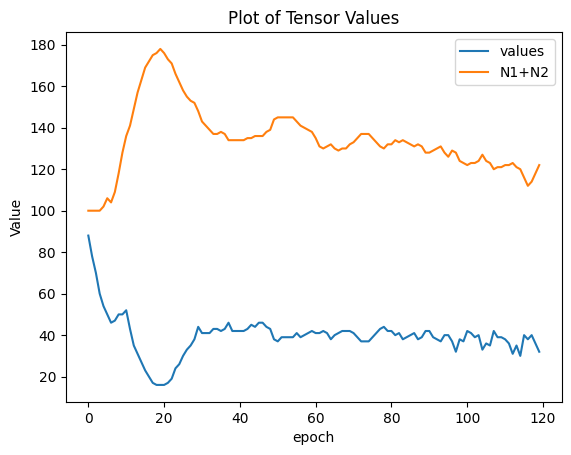

tensor(39.5000, grad_fn=<DivBackward0>)


In [697]:
import matplotlib.pyplot as plt

# Extract the values from the tensors
values = [tensor.item() for tensor in losses]

# Plot the values
plt.plot(values, label='values')
plt.plot(N, label='N1+N2')
plt.xlabel('epoch')
plt.ylabel('Value')
plt.title('Plot of Tensor Values')
plt.legend()
plt.show()


print((sum(losses)/len(losses)))

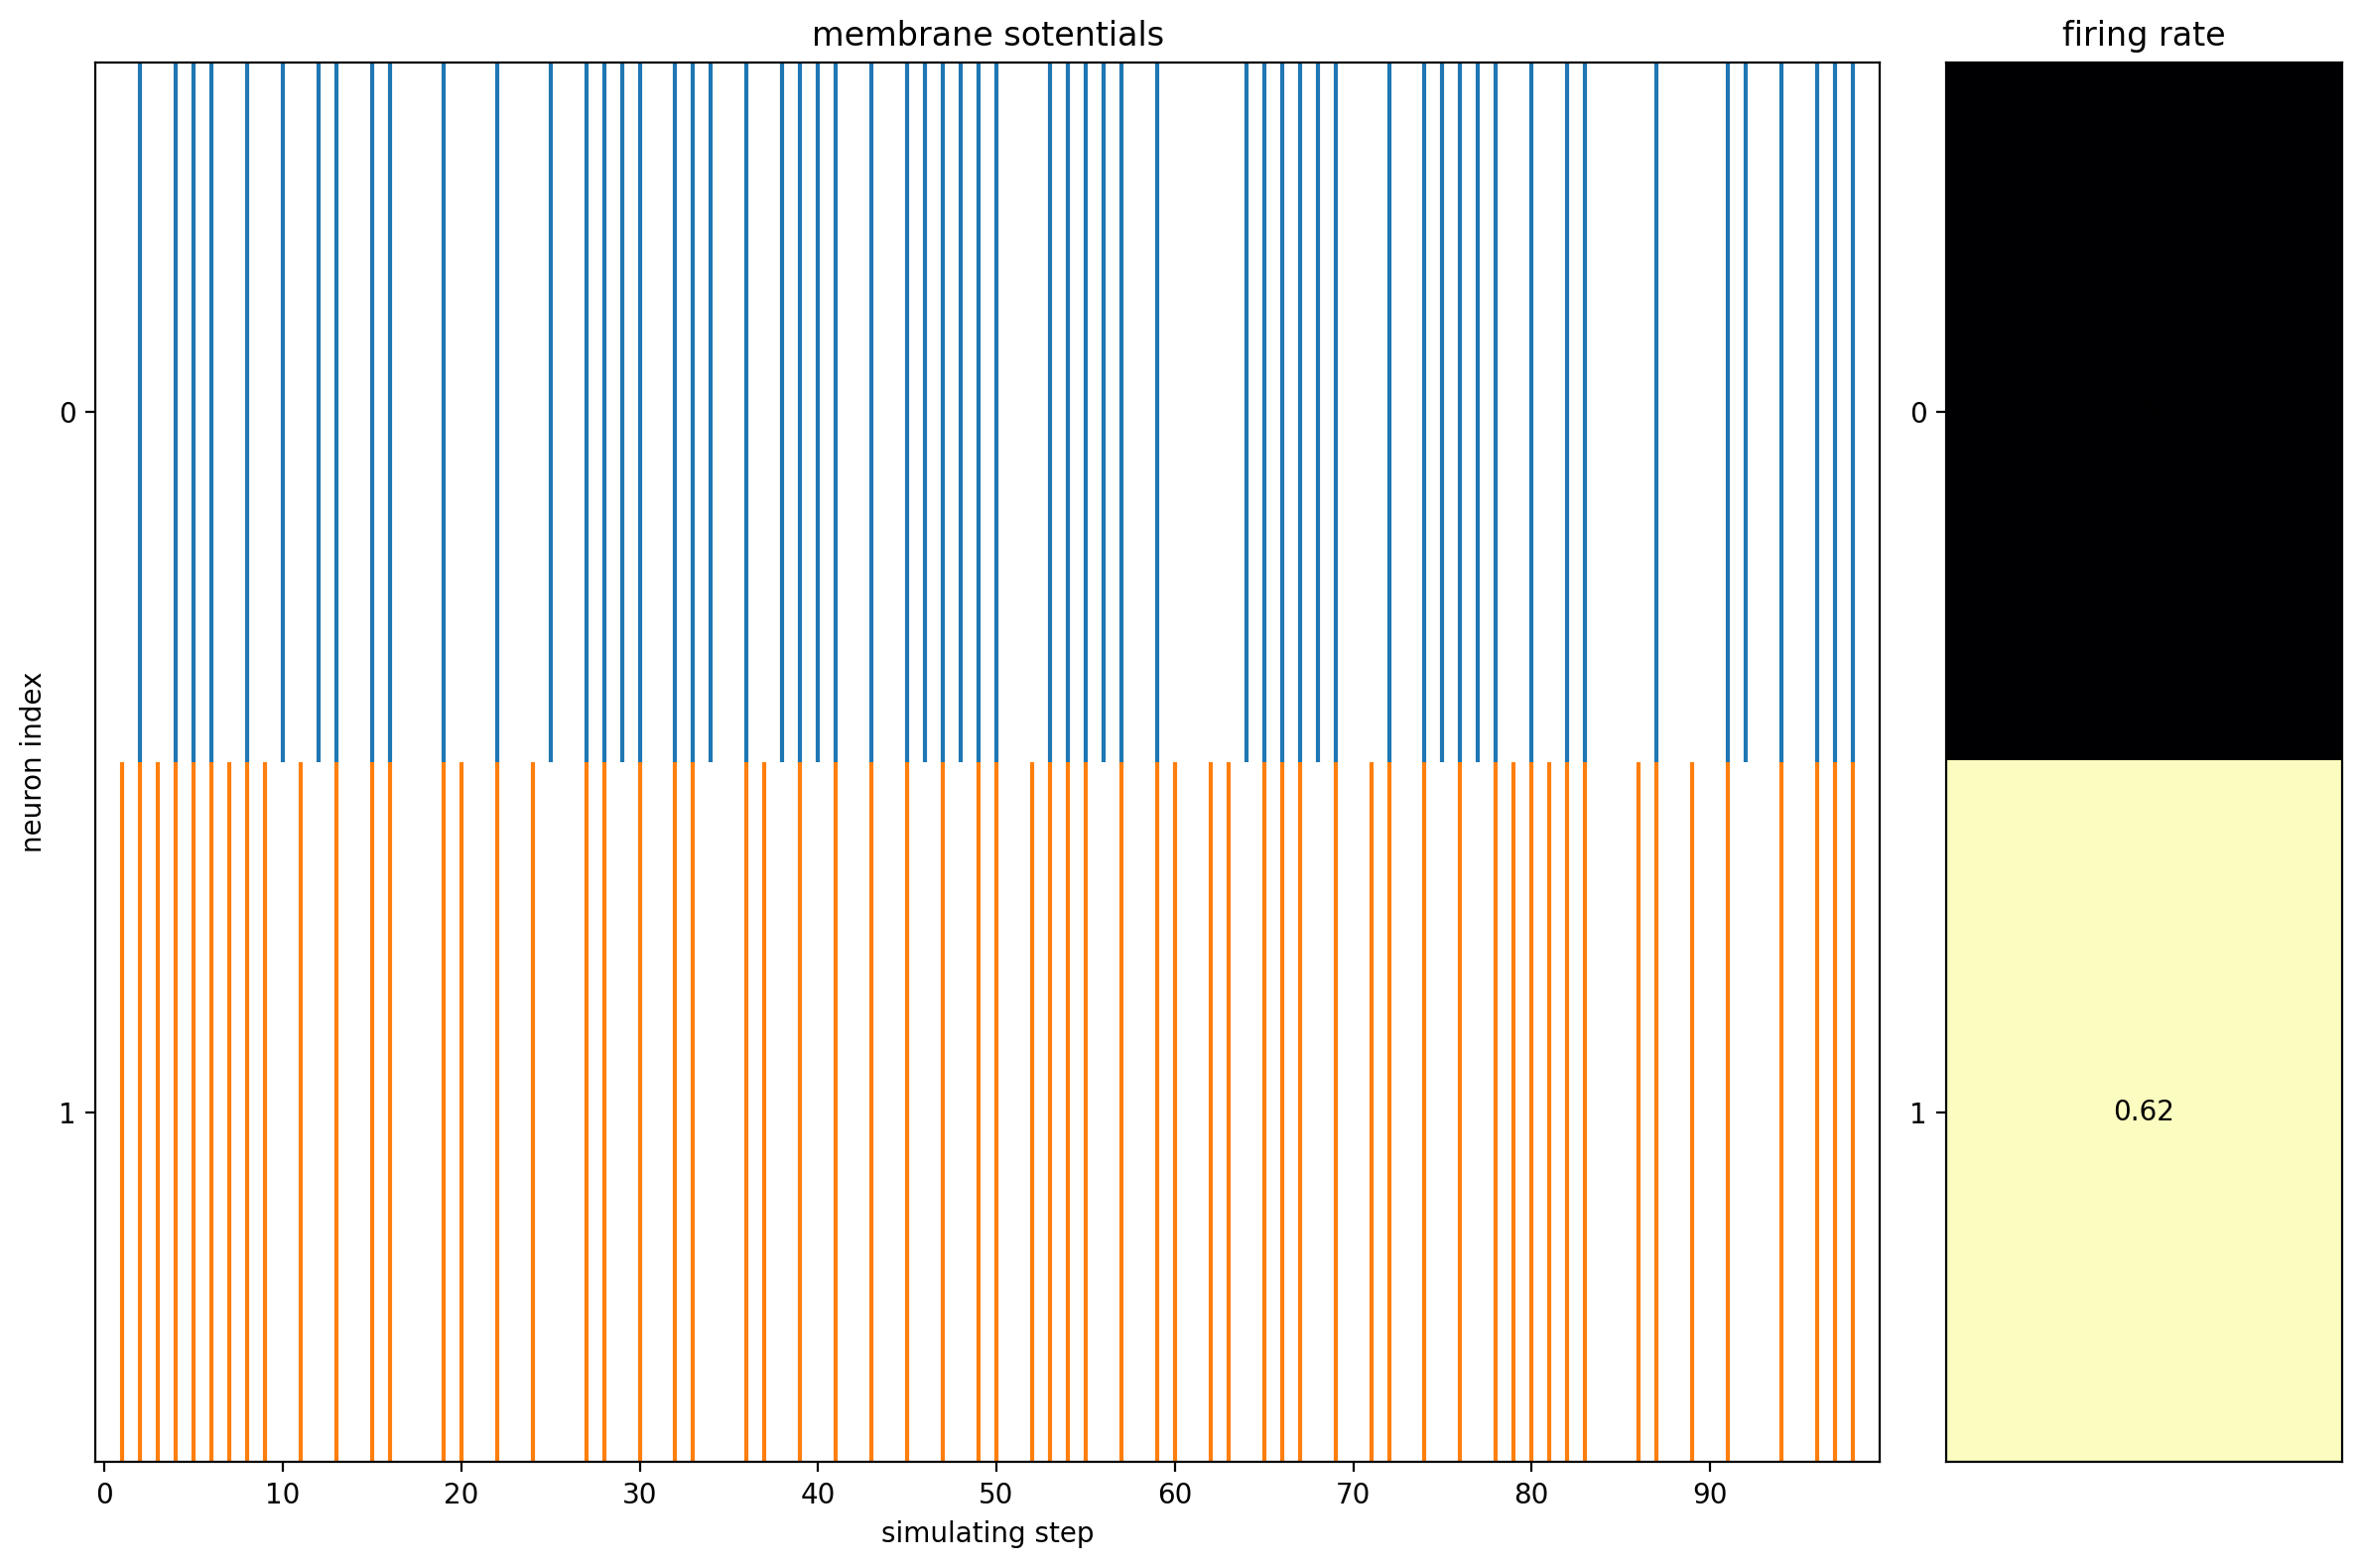

In [699]:
from spikingjelly import visualizing

s_list = torch.cat((record[0 , :].reshape(-1,1) , record[1 , :].reshape(-1 , 1)) , dim = 1)
s_list.shape

figsize = (12, 8)
dpi = 200

visualizing.plot_1d_spikes(spikes=s_list.detach().numpy(), title='membrane sotentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()

In [750]:
T = 100
spikes = torch.tensor(PoissonSpike(np.random.random(100),time=T,dt=1 , max_freq = 2500 , min_freq = 1800).spikes).float()
network = test(layer1_number = 100)

epoch_record = []
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3 )
losses = []
N = []


for epoch in range(200):

    network.train()
    loss = 0

    optimizer.zero_grad()


    for t in range (T):

        out_fr , layers_spikes , w = network(spikes[: , t])
        
        if t == 0 :

            record = layers_spikes[0].reshape(-1 , 1)


        else :

            record = torch.cat((record , layers_spikes[0].reshape(-1 , 1)) , dim = 1)



    loss1 , N1 = coincidence_single_profile_cython(record[0 , :], record[1 , :], 0 , 99 , max_tau = 2)
    loss2 , N2 = coincidence_single_profile_cython(record[1 , :], record[0 , :], 0 , 99 , max_tau = 2)

    loss = loss1 + loss2 + (0.5)*(torch.sum(torch.pow(record[0 , :], 2)) + torch.sum(torch.pow(record[1 , :], 2)))
    

    
    print(N1+N2)
    N.append(N1+N2)
    losses.append(loss1+loss2)
    loss.backward(retain_graph = True)
    print("total loss" , loss)
    print("synchrony loss" ,  loss1 + loss2)
    print (record)
    optimizer.step()
    functional.reset_net(network)



98
total loss tensor(147., grad_fn=<AddBackward0>)
synchrony loss tensor(98., grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0

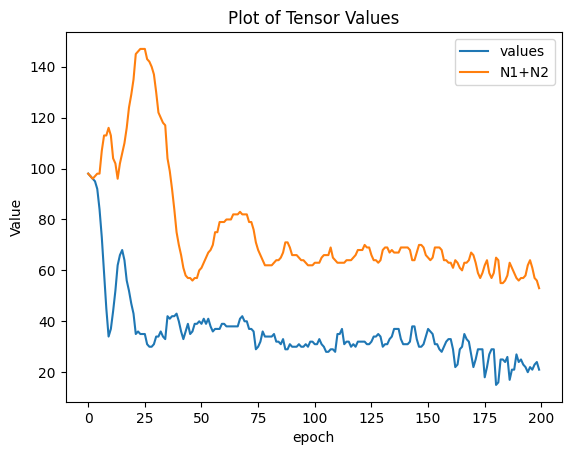

tensor(35.4450, grad_fn=<DivBackward0>)


In [751]:
import matplotlib.pyplot as plt

# Extract the values from the tensors
values = [tensor.item() for tensor in losses]

# Plot the values
plt.plot(values, label='values')
plt.plot(N, label='N1+N2')
plt.xlabel('epoch')
plt.ylabel('Value')
plt.title('Plot of Tensor Values')
plt.legend()
plt.show()


print((sum(losses)/len(losses)))

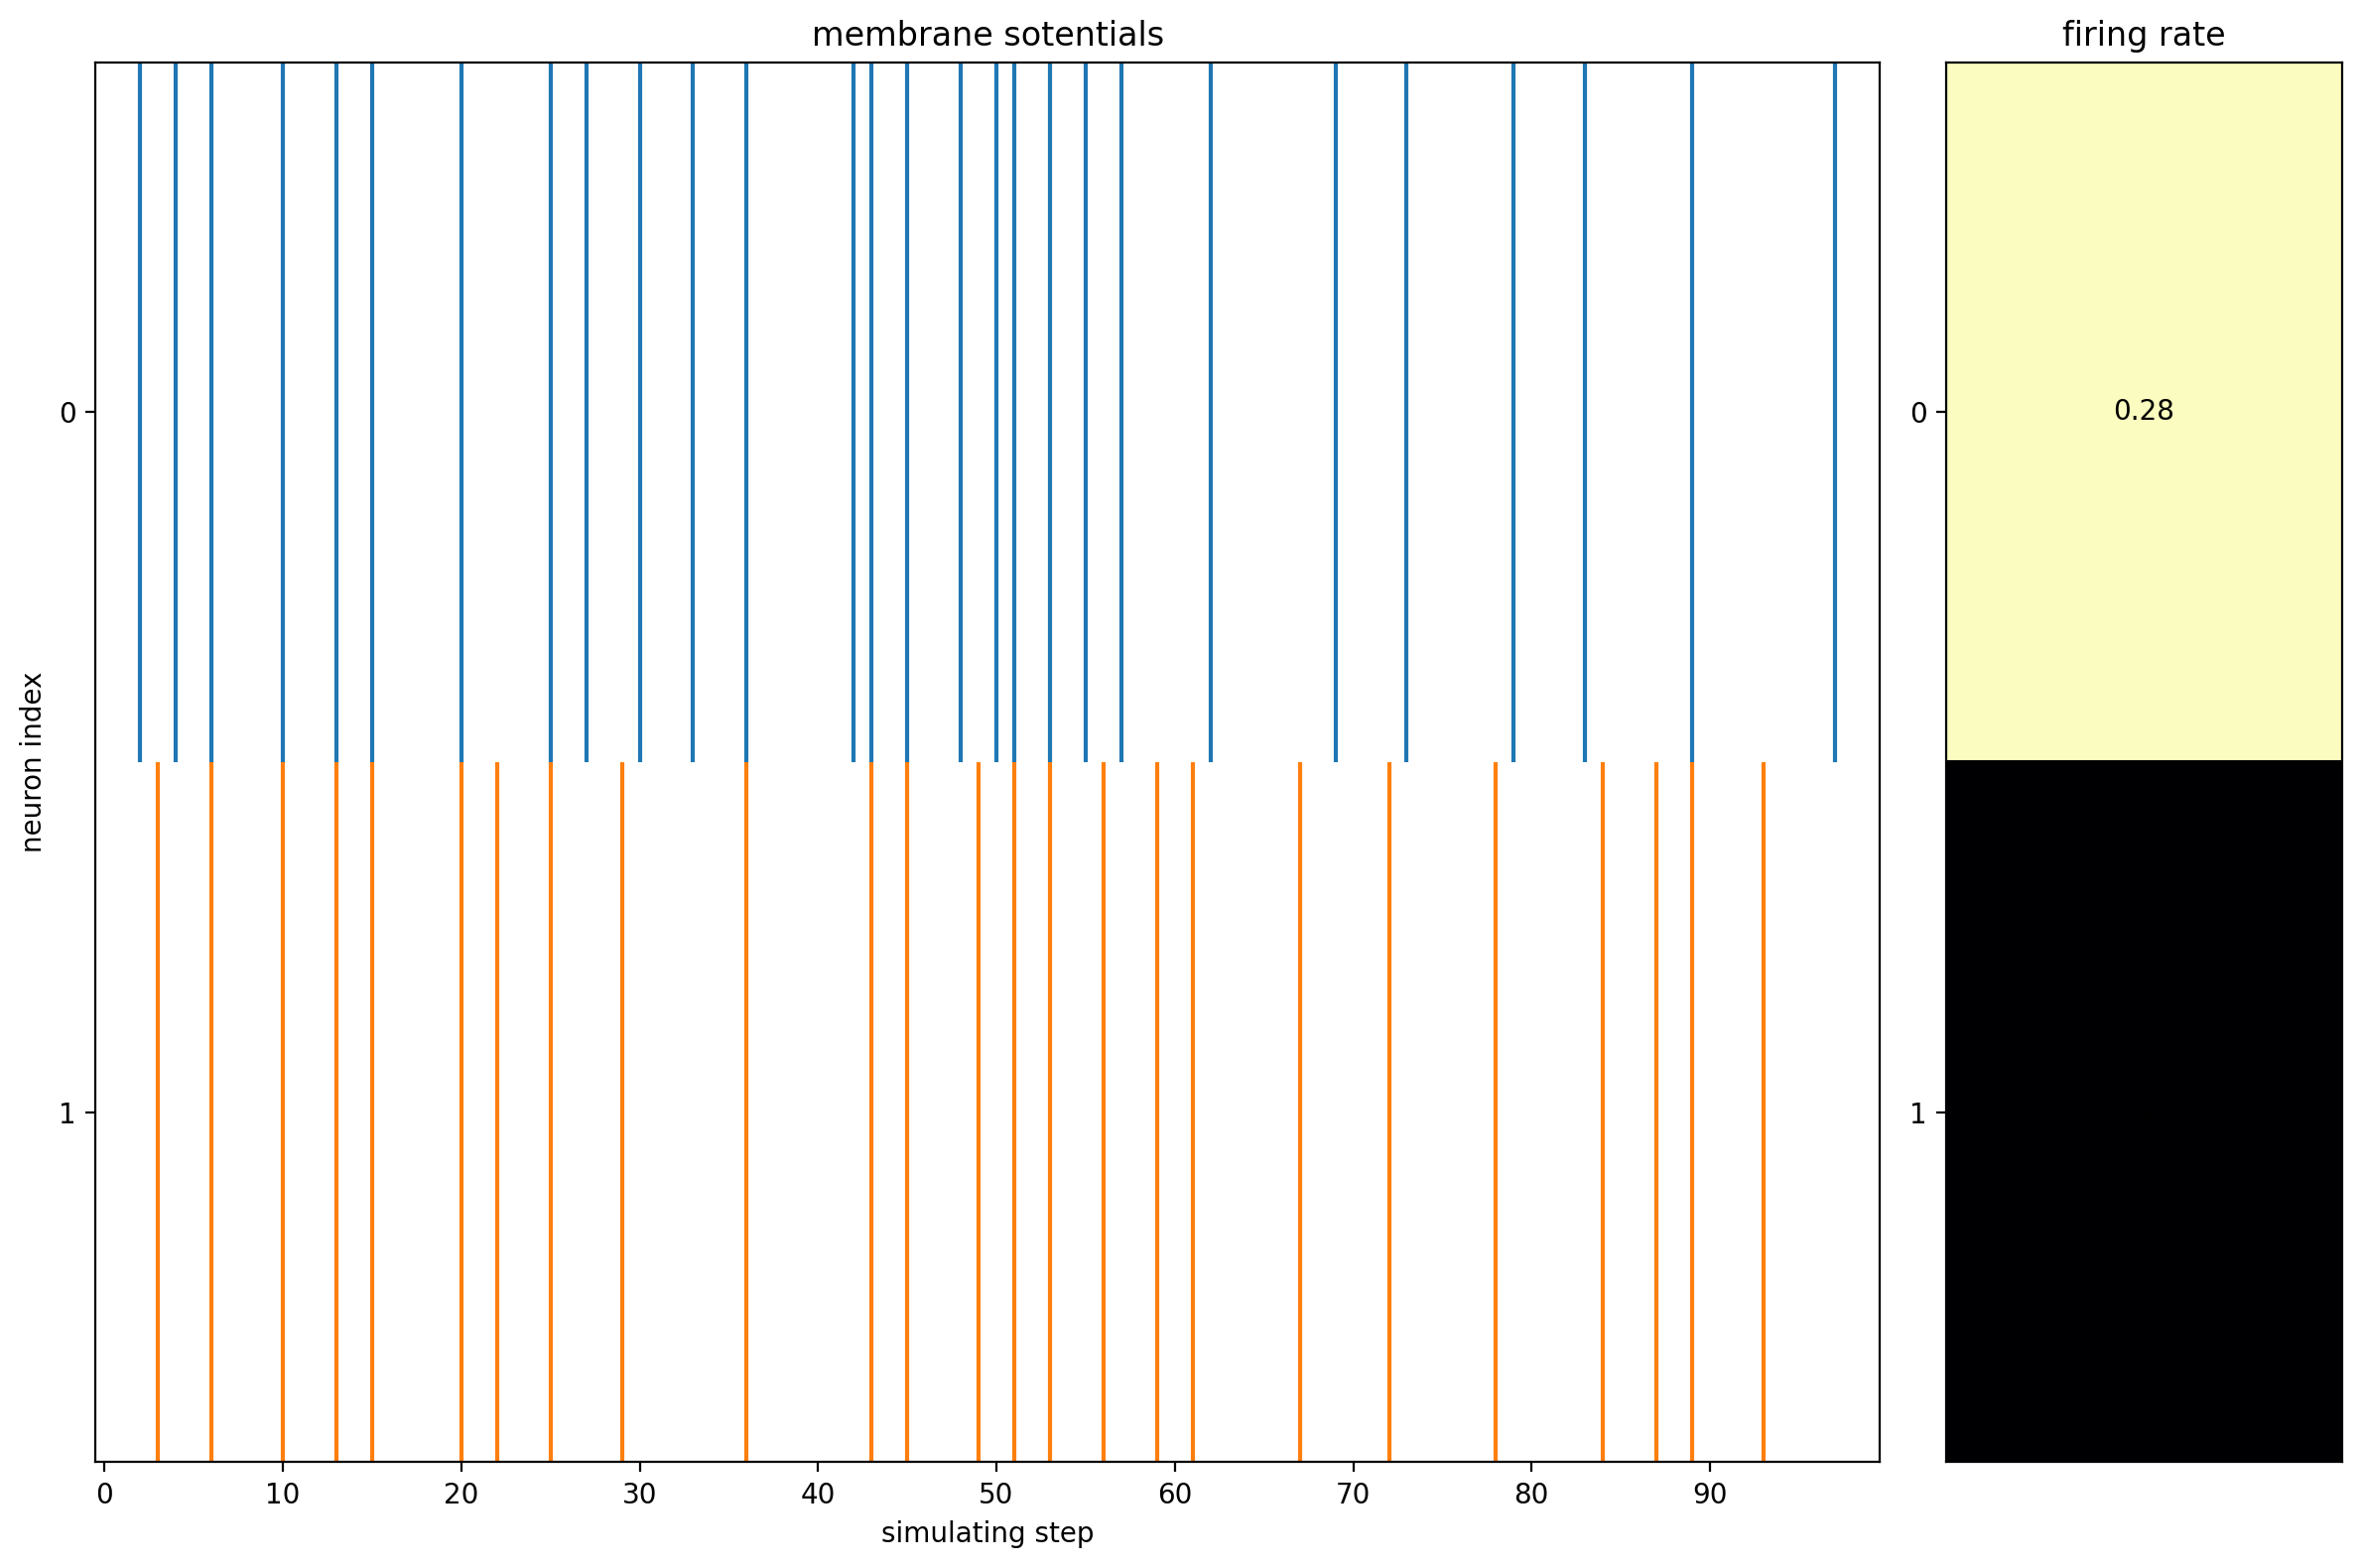

53


In [752]:
from spikingjelly import visualizing

s_list = torch.cat((record[0 , :].reshape(-1,1) , record[1 , :].reshape(-1 , 1)) , dim = 1)
s_list.shape

figsize = (12, 8)
dpi = 200

visualizing.plot_1d_spikes(spikes=s_list.detach().numpy(), title='membrane sotentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()
print(N[-1])

In [703]:
T = 100
spikes = torch.tensor(PoissonSpike(np.random.random(100),time=T,dt=1 , max_freq = 2500 , min_freq = 1800).spikes).float()
network = test(layer1_number = 100)

epoch_record = []
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3 )
losses = []
N = []
error = []


for epoch in range(200):

    network.train()
    loss = 0

    optimizer.zero_grad()


    for t in range (T):

        out_fr , layers_spikes , w = network(spikes[: , t])
        
        if t == 0 :

            record = layers_spikes[0].reshape(-1 , 1)


        else :

            record = torch.cat((record , layers_spikes[0].reshape(-1 , 1)) , dim = 1)



    loss1 , N1 = coincidence_single_profile_cython(record[0 , :], record[1 , :], 0 , 99 , max_tau = 2)
    loss2 , N2 = coincidence_single_profile_cython(record[1 , :], record[0 , :], 0 , 99 , max_tau = 2)
    loss = loss1 + loss2


    # Define the Gaussian kernel
    kernel_size = 5
    sigma = 1.0
    kernel = torch.exp(-(torch.arange(kernel_size) - kernel_size // 2) ** 2 / (2 * sigma ** 2))
    
    # Normalize the kernel
    kernel = kernel / kernel.sum()
    
    
    # Add a dimension to match the tensor shape
    kernel = kernel.unsqueeze(0).unsqueeze(0)
    
    # Apply the convolution
    vector1 = (F.conv1d(record[0 , :].unsqueeze(0).unsqueeze(0), kernel)).squeeze()
    vector2 = (F.conv1d(record[1 , :].unsqueeze(0).unsqueeze(0), kernel)).squeeze()
    
    #dot product of vector1 and vector2

    dotproduct = torch.dot(vector1 , vector2)

    loss = dotproduct - torch.norm(vector1)*torch.norm(vector2)

    
    
    print("total number of spikes" , N1+N2)
    N.append(N1+N2)
    losses.append(loss)
    loss.backward(retain_graph = True)
    print("synchrony loss" ,  loss1 + loss2)
    print (record)
    optimizer.step()
    functional.reset_net(network)



total number of spikes 126
synchrony loss tensor(68., grad_fn=<AddBackward0>)
tensor([[0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
         0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]], grad_fn=<Ca

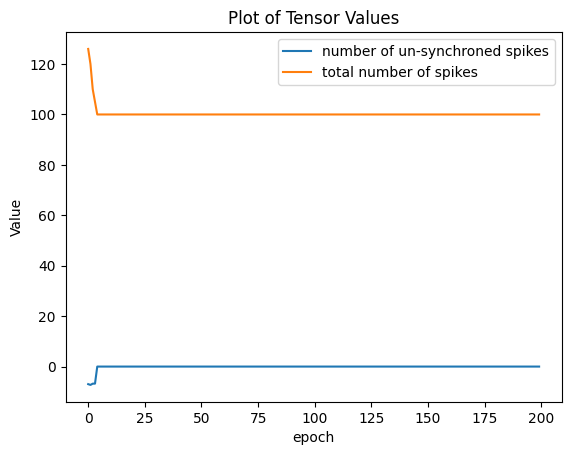

In [704]:
import matplotlib.pyplot as plt

values = []
# Extract the values from the tensors
for tensor in losses :

    if tensor == 0 :

        values.append(tensor.item())

    else:

        values.append(tensor.item())


# Plot the values
plt.plot(values, label='number of un-synchroned spikes')
plt.plot(N, label='total number of spikes')

plt.xlabel('epoch')
plt.ylabel('Value')
plt.title('Plot of Tensor Values')
plt.legend()
plt.show()

print()

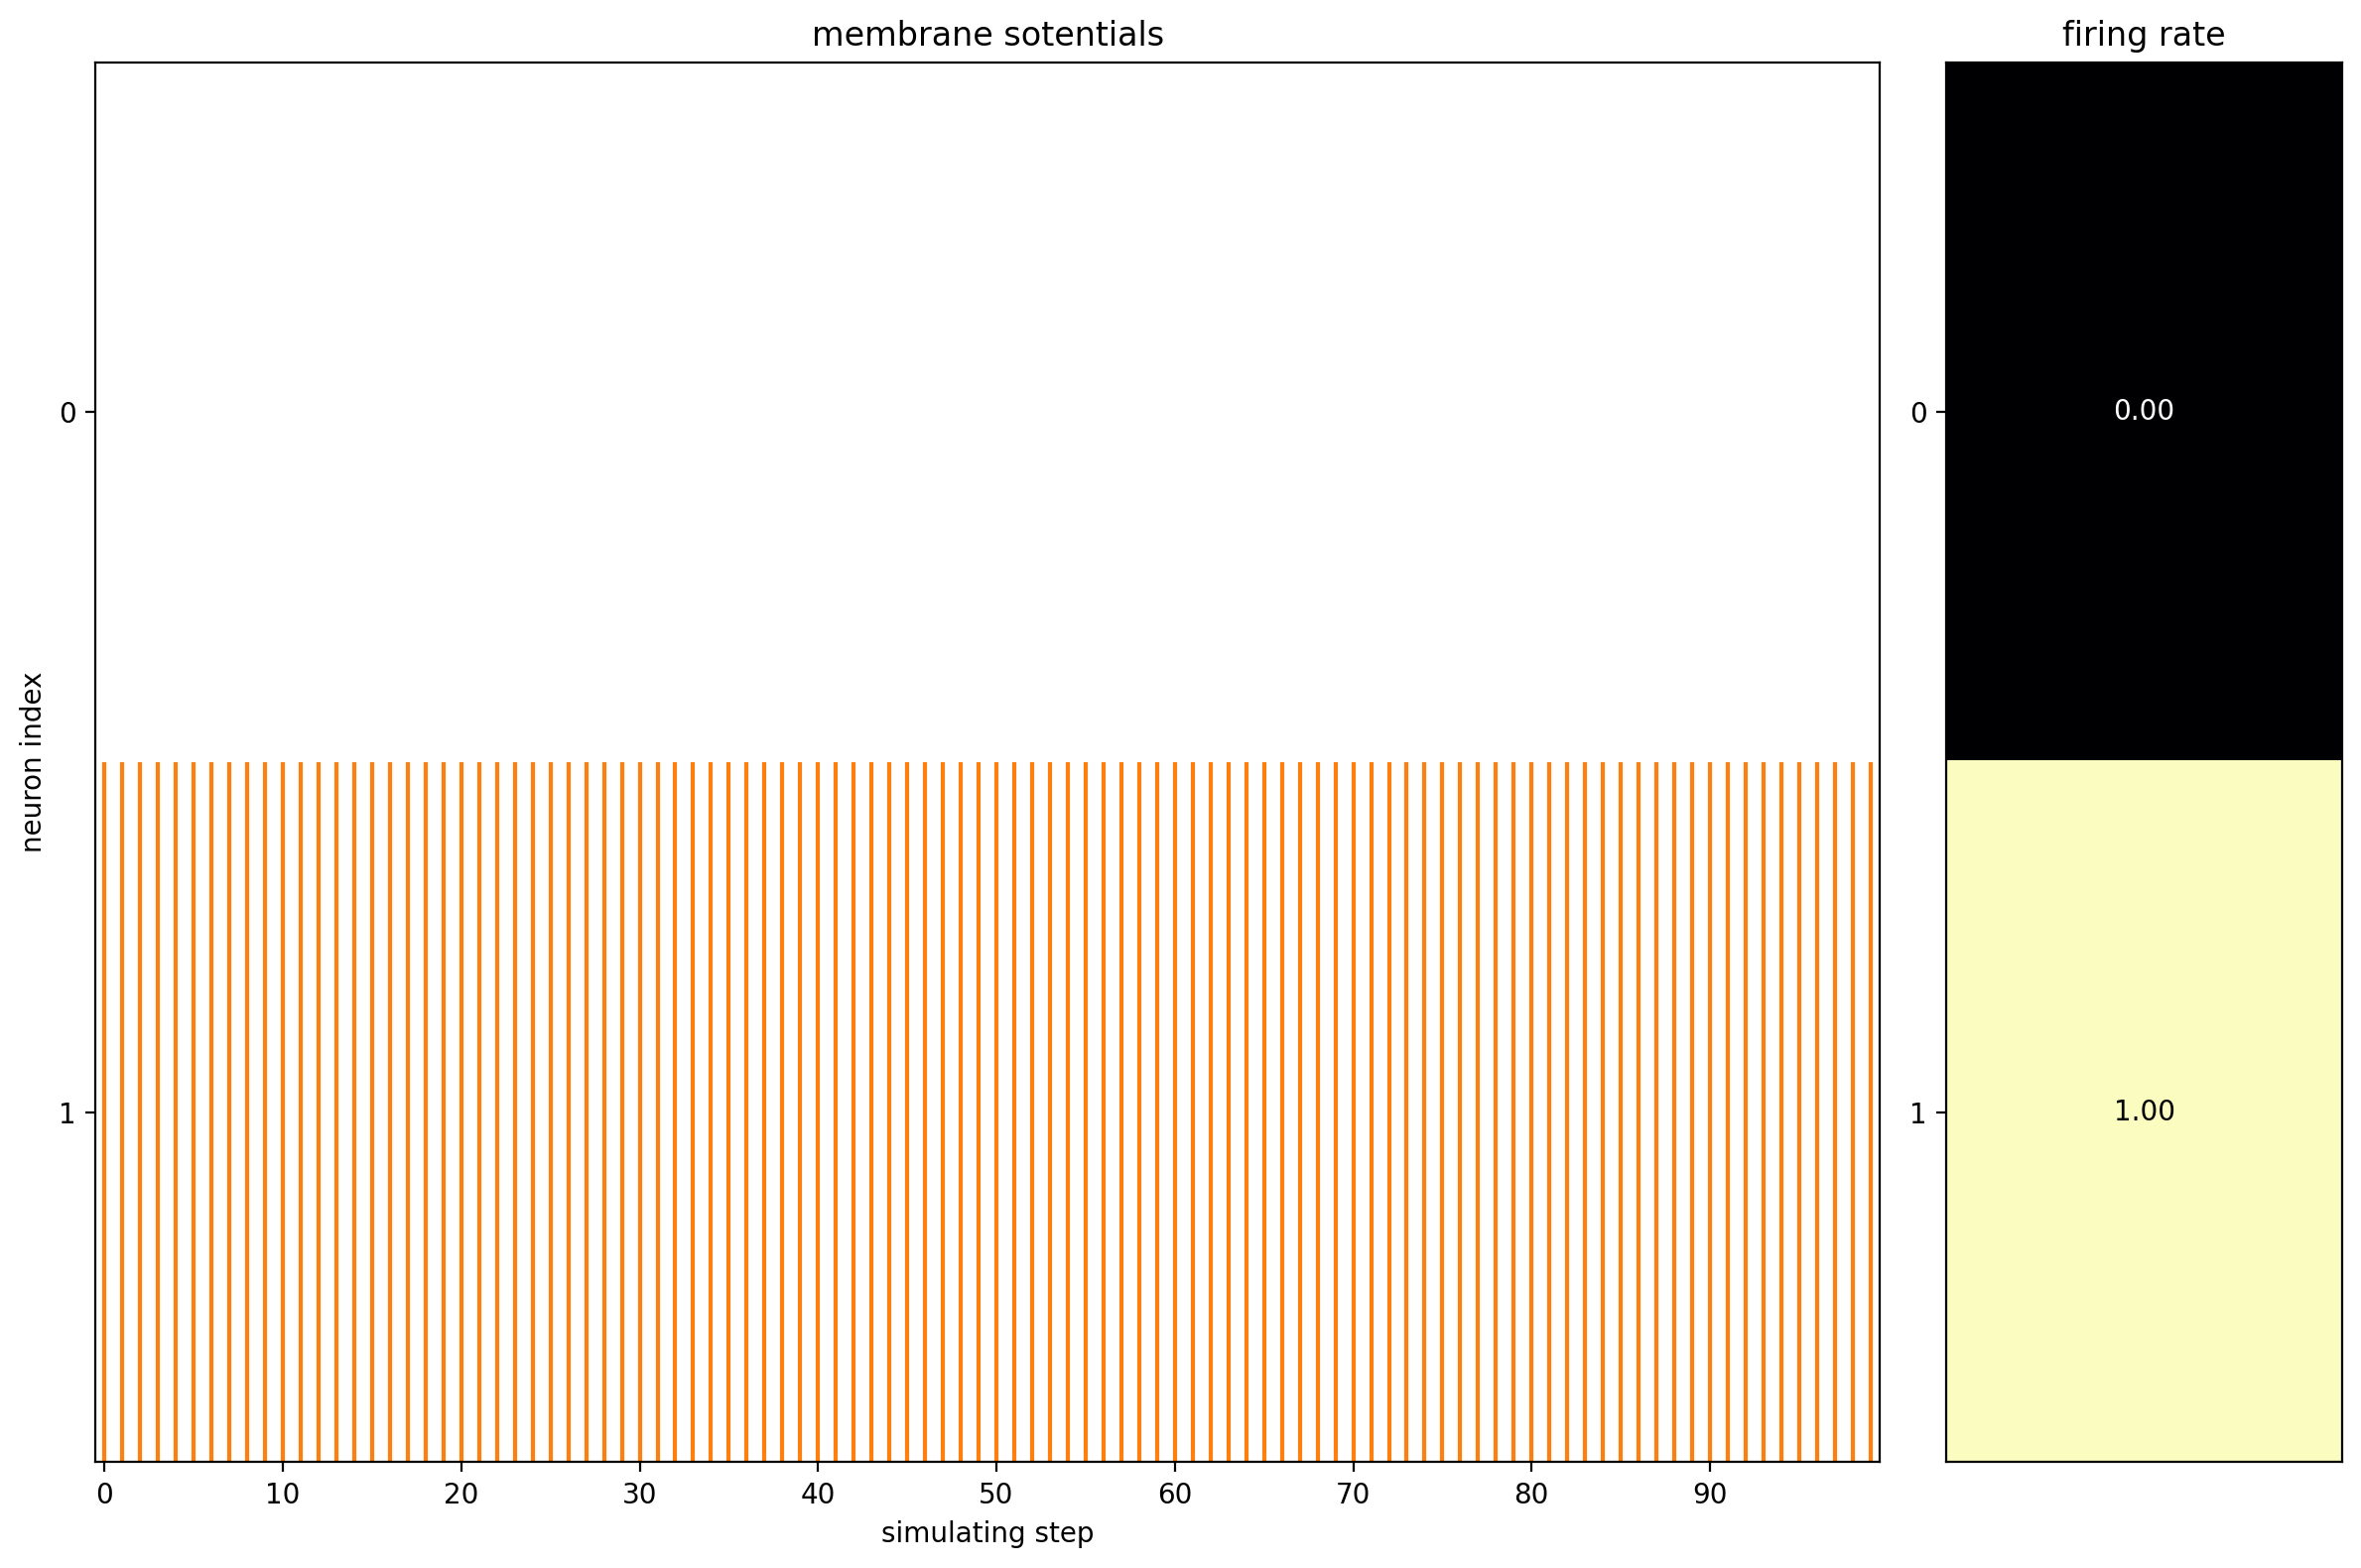

In [705]:
from spikingjelly import visualizing

s_list = torch.cat((record[0 , :].reshape(-1,1) , record[1 , :].reshape(-1 , 1)) , dim = 1)
s_list.shape

figsize = (12, 8)
dpi = 200

visualizing.plot_1d_spikes(spikes=s_list.detach().numpy(), title='membrane sotentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()

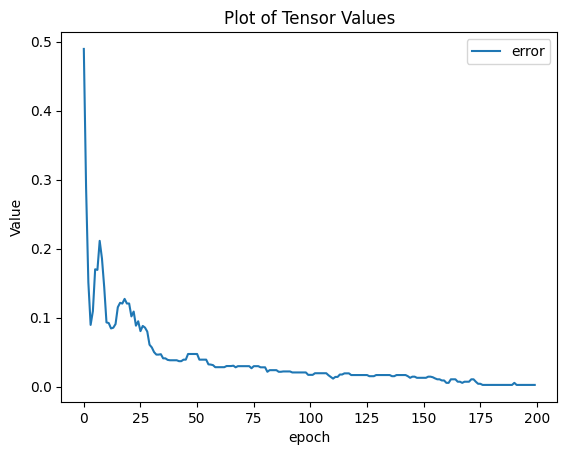

In [577]:
import matplotlib.pyplot as plt

# Plot the values

plt.plot(error , label='error')

plt.xlabel('epoch')
plt.ylabel('Value')
plt.title('Plot of Tensor Values')
plt.legend()
plt.show()

In [ ]:
T = 100
spikes = torch.tensor(PoissonSpike(np.random.random(100),time=T,dt=1 , max_freq = 2500 , min_freq = 1800).spikes).float()
network = test(layer1_number = 100)

epoch_record = []
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-3 )
losses = []
N = []
error = []


for epoch in range(200):

    network.train()
    loss = 0

    optimizer.zero_grad()


    for t in range (T):

        out_fr , layers_spikes , w = network(spikes[: , t])
        
        if t == 0 :

            record = layers_spikes[0].reshape(-1 , 1)


        else :

            record = torch.cat((record , layers_spikes[0].reshape(-1 , 1)) , dim = 1)



    loss1 , N1 = coincidence_single_profile_cython(record[0 , :], record[1 , :], 0 , 99 , max_tau = 2)
    loss2 , N2 = coincidence_single_profile_cython(record[1 , :], record[0 , :], 0 , 99 , max_tau = 2)
    loss = loss1 + loss2


    # Define the Gaussian kernel
    kernel_size = 5
    sigma = 1.0
    kernel = torch.exp(-(torch.arange(kernel_size) - kernel_size // 2) ** 2 / (2 * sigma ** 2))
    
    # Normalize the kernel
    kernel = kernel / kernel.sum()
    
    
    # Add a dimension to match the tensor shape
    kernel = kernel.unsqueeze(0).unsqueeze(0)
    
    # Apply the convolution
    vector1 = (F.conv1d(record[0 , :].unsqueeze(0).unsqueeze(0), kernel)).squeeze()
    vector2 = (F.conv1d(record[1 , :].unsqueeze(0).unsqueeze(0), kernel)).squeeze()
    
    squared_diffs = (vector1 - vector2) ** 2

    
    # Calculate the MSE
    mse = squared_diffs.mean()

    loss = mse + 


    
    

    print("MSE:", mse) 
    error.append(mse.item())
    print("total number of spikes" , N1+N2)
    N.append(N1+N2)
    losses.append(loss1+loss2)
    mse.backward(retain_graph = True)
    print("synchrony loss" ,  loss1 + loss2)
    print (record)
    optimizer.step()
    functional.reset_net(network)



## Regularization

In [ ]:
def regularization(batch_activation , max_tau):


        s = []

        

        for i in range(len(batch_activation)): # which Layer
            for j in range(0 , len(batch_activation[i]) - 1): # first Neuron
                for k in range( j+1 , len(batch_activation[i])): # second Neuron

                    neuron1 = batch_activation[i][j]
                    neuron2 = batch_activation[i][k]

                    for l in range((batch_activation[i][k]).size(0)):

                        spiketrain1 = batch_activation[i][j][l , :]
                        spiketrain2 = batch_activation[i][k][l , :]

                        s.append(calc(spiketrain1 , spiketrain2 ، j , k , max_tau))


                        


                        
                        


                        

                        

                        




                    
                

                

    